# Analyzing NYC Subway Data

##Introduction

In the following analysis, I will be utilizing a dataset containing New York City MTA Subway ridership as well as some relevant weather data pertaining to each period.  The goal of this analysis will be to determine whether subway ridership varies during periods of rain and to build a predictive model for subway ridership, as well as to explore visualizations and various other tools within pandas.

Link to the dataset and reference materials can be found in the "References" section at the end.

Analysis by [Justin McCarty](https://www.linkedin.com/in/justindmccarty)

##Section 0. Importing and View of the Data

In [2]:
# Import the data:
import pandas
weather_data = pandas.read_csv('turnstile_weather_V2.csv')

In [3]:
# View the structure of the DataFrame
weather_data.head()

,UNIT,DATEn,TIMEn,ENTRIESn,EXITSn,ENTRIESn_hourly,EXITSn_hourly,datetime,hour,day_week,...,pressurei,rain,tempi,wspdi,meanprecipi,meanpressurei,meantempi,meanwspdi,weather_lat,weather_lon
0,R003,05-01-11,00:00:00,4388333,2911002,0,0,2011-05-01 00:00:00,0,6,...,30.22,0,55.9,3.5,0,30.258,55.98,7.86,40.700348,-73.887177
1,R003,05-01-11,04:00:00,4388333,2911002,0,0,2011-05-01 04:00:00,4,6,...,30.25,0,52.0,3.5,0,30.258,55.98,7.86,40.700348,-73.887177
2,R003,05-01-11,12:00:00,4388333,2911002,0,0,2011-05-01 12:00:00,12,6,...,30.28,0,62.1,6.9,0,30.258,55.98,7.86,40.700348,-73.887177
3,R003,05-01-11,16:00:00,4388333,2911002,0,0,2011-05-01 16:00:00,16,6,...,30.26,0,57.9,15.0,0,30.258,55.98,7.86,40.700348,-73.887177
4,R003,05-01-11,20:00:00,4388333,2911002,0,0,2011-05-01 20:00:00,20,6,...,30.28,0,52.0,10.4,0,30.258,55.98,7.86,40.700348,-73.887177


In [12]:
# List of column names (since the DataFrame.head() cuts some of them out) so we can see what we are working with:
weather_data.columns

Index([u'UNIT', u'DATEn', u'TIMEn', u'ENTRIESn', u'EXITSn', u'ENTRIESn_hourly',
       u'EXITSn_hourly', u'datetime', u'hour', u'day_week', u'weekday',
       u'station', u'latitude', u'longitude', u'conds', u'fog', u'precipi',
       u'pressurei', u'rain', u'tempi', u'wspdi', u'meanprecipi',
       u'meanpressurei', u'meantempi', u'meanwspdi', u'weather_lat',
       u'weather_lon'],
      dtype='object')

In [13]:
# View plots within the Notebook:
%matplotlib inline

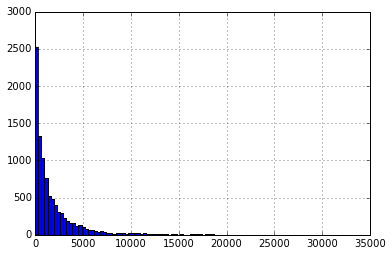

In [14]:
# View the distribution of rainy days (plot histogram with pandas and matplotlib):
import numpy as np
import matplotlib.pyplot as plt

weather_data[weather_data.rain == 1]['ENTRIESn_hourly'].hist(bins = 100)

## Section 1. Statistical Test

As mentioned in the introduction, we want to analyze NYC subway data - and more specifically subway data as it relates to the differences in ridership between periods when there is rain and periods when there is not.  we will perform a Mann Whitney U-test on the means of the hourly entries for both groups (with_rain and without_rain).  

We approach the question with the Null Hypothesis that the mean entries for both with_rain and without_rain are equal.  In the case of rejecting the Null Hypothesis, because we don't have certainty around the effect of rain on ridership, we will use a two tailed test with a p-critical value of 0.025 (aiming for 95% significance).

Since the distributions are both similarly shaped and unmatched, we can use a Mann Whitney test.  We have chosen a two-tailed test because, in the event that we do reject the Null Hypothesis, it is plausible that rain could either increase or decrease subway ridership.

In [23]:
# The following function will return the mean hourly entries for both groups
# as well as the U statistic and P-Value resulting from the Mann Whitney test.
import numpy as np
import scipy
import scipy.stats
import pandas

def mann_whitney_plus_means(weather_data):
    with_rain = weather_data[weather_data.rain == 1]['ENTRIESn_hourly']
    without_rain = weather_data[weather_data.rain == 0]['ENTRIESn_hourly']
    with_rain_mean = np.mean(with_rain)
    without_rain_mean = np.mean(without_rain)
    (U,p) = scipy.stats.mannwhitneyu(with_rain, without_rain, use_continuity=True)
    
    return with_rain_mean, without_rain_mean, U, p

In [24]:
# Execute the function on the data:
mann_whitney_plus_means(weather_data)

(2028.1960354720918, 1845.5394386644084, 153635120.5, 2.7410695712437496e-06)

Interpretation: Mean entries in groups with_rain and without_rain were 2028 and 1846 entries per hour; the mean ridershop in the two groups differed significantly (Mann–Whitney U = 153635121, P < 0.025 two-tailed).  This would lead us to reject the Null Hypothesis and accept the Alternate Hypothesis that the means are not equal.  That is, that rain does have an effect on subway ridership.

##Section 2. Linear Regression

In Section 2, I apply a simple linear regression from the Scikit Learn Package.  The LinearRegression function fits uses least squares to calculate the coefficients to be applied to each feature in calculating a predicted value. To do this, I used 'rain', 'weekday', and 'hour' as features based on an intuition as to what may drive the subway ridership.  
* rain: We know from our statistical test previously that rain does have an effect on ridership, so I will continue to use it as a feature in our model.
* weekday: I believe weekday will be a strong predictor as communing tredns in NYC are different between weekdays and weekends and thus (I predict) affect subway ridership.
* hour: I believe hour of the day would have an effect on ridership patterns due to the time that people move around cities based on work and dinner.

The model uses dummy values for any items that may not have been populated / filled in, etc.

In [25]:
# We will create a function to perform a linear regression on the data using the sklearn package
# This is a separate function from feature selection so that we can modify features as needed
from sklearn.linear_model import LinearRegression

def linear_regression(features, values):
    model = LinearRegression(fit_intercept=True)
    model.fit(features, values)
    intercept = model.intercept_
    params = model.coef_
    return intercept, params

In [74]:
# Uses the linear regression function on selected features:
def predictions(dataframe):
    # Final set of features selected were rain, weekday, hour
    features = dataframe[['rain', 'weekday', 'hour']]
    dummy_units = pandas.get_dummies(dataframe['UNIT'], prefix='unit')
    features = features.join(dummy_units)
    
    # Values
    values = dataframe['ENTRIESn_hourly']

    # Perform linear regression
    intercept, params = linear_regression(features, values)
    
    predictions = intercept + np.dot(features, params)
    return predictions

In [75]:
# Run for my selected features:
predictionsv1 = predictions(weather_data)

In [76]:
# Create a function to plot the residuals:
def plot_residuals(weather_data, predictions):
    plt.figure()
    (weather_data['ENTRIESn_hourly'] - predictions).hist(bins=100)
    return plt

<module 'matplotlib.pyplot' from '/Users/justinnmccarty/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

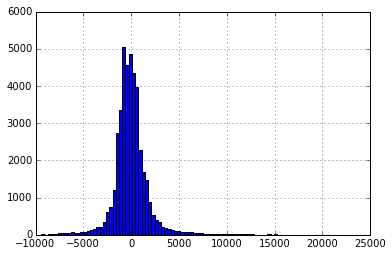

In [91]:
# Plotting the residuals (ideally the distribution would be very narrow and high, around 1):
plot_residuals(weather_data, predictionsv1)

In [85]:
# Determining the coefficients or parameters:
def coefficients(dataframe):
    # Final set of features selected were rain, precipitation, weekday, hour
    features = dataframe[['rain', 'weekday', 'hour']]
    dummy_units = pandas.get_dummies(dataframe['UNIT'], prefix='unit')
    features = features.join(dummy_units)
    
    # Values
    values = dataframe['ENTRIESn_hourly']

    # Perform linear regression
    #intercept, params = linear_regression(features, values)
    model = LinearRegression(fit_intercept=True)
    model.fit(features, values)
    intercept = model.intercept_
    params = model.coef_
    #return intercept, params
    
    #predictions = intercept + np.dot(features, params)
    return model.coef_[0], model.coef_[1], model.coef_[2] #, model.coef_[3]

In [86]:
# Show parameters (also known as "coefficients" or "weights") of the non-dummy features 
# in the linear regression model:
coefficients(weather_data)

(37.011837964983727, 976.88969253486971, 123.38631109134218)

In [80]:
# Create a function to compute the R^2 calculation:
import sys

def compute_r_squared(data, predictions):    
    SST = ((data - np.mean(data))**2).sum()
    SSReg = ((predictions - data)**2).sum()
    r_squared = 1 - SSReg / SST
    
    return r_squared

In [81]:
# Convert the DataFrame column into an array that can be used in the R^2 calculation:
actuals = weather_data['ENTRIESn_hourly']

In [82]:
# Execute and determine the R^2 between our actual data and predicted values:
compute_r_squared(actuals, predictionsv1)

0.48139642697873553

Interpretation of the R2 value: The R2 value indicates the model explains nearly half of the ridership for any given hour.  There are clearly some things (or something) causing significant variance not accounted for with the model.  The model seems to be reasonably suited to predicting ridership (as a human behavior, I understand ~50% R squared to be relatively adequate).

##Section 3. Visualization

The first visualization contains two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days:

In [120]:
# View Rain / Without Rain together:
def entries_histogram(weather_data):
    plt.figure()
    weather_data[weather_data.rain == 0]['ENTRIESn_hourly'].hist(bins = 100, label = "Without Rain") 
    weather_data[weather_data.rain == 1]['ENTRIESn_hourly'].hist(bins = 100, label = "With Rain") 
    plt.legend()
    plt.xlabel('Hourly Entries')
    plt.ylabel('Frequency')
    plt.title('Histogram of Subway Entries: With and Without Rain')
    return plt

<module 'matplotlib.pyplot' from '/Users/justinnmccarty/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

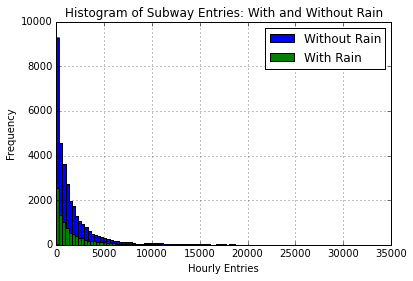

In [121]:
entries_histogram(weather_data)

In the next visualization, we look at the ridership by mean temperature.  I have also split this out by rain or no rain, but it is not immediately noticeable if that is helpful or not.  I have also attempted this plot in the ggplot lobrary:

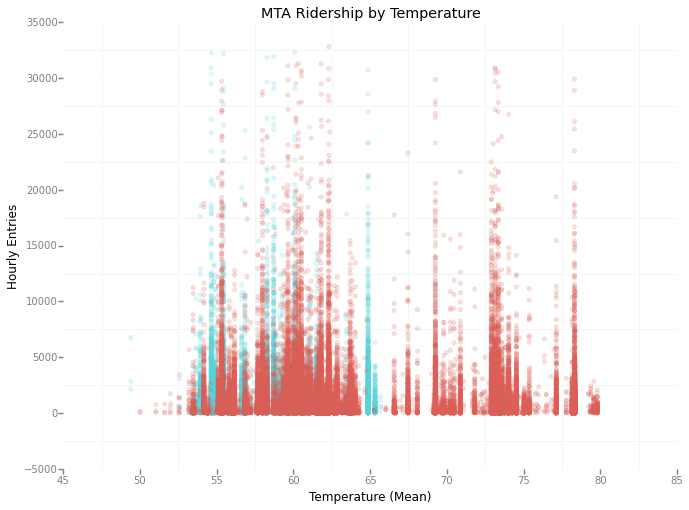

<ggplot: (552742565)>

In [161]:
from ggplot import *
ggplot(aes(x='meantempi',y='ENTRIESn_hourly', color='rain'), data=weather_data) +\
    geom_point(alpha=0.2) +\
    theme_bw() +\
    labs(title ="MTA Ridership by Temperature", x = "Temperature (Mean)", y = "Hourly Entries") 
    

##Section 4. Conclusion

Based on my analysis of the means and the Mann Whitney test, there is a significant increase in ridership during periods where there is rain.  In addition to the statistical test, rain as a coefficient to the LinearRegression model had a positive lift on the predicted ridership when present, also indicating increased ridership during periods when rain is present and / or occuring.

##Section 5. Reflection

There are large outliers and significant variability in the dataset.  Items like holidays, parades, etc. are not accounted for in the dataset and may have a significantimpact on subway ridership within New York.  In addition to "events" data, I would ideally spend some more time splicing the data by various dates.  For example, in the last visualization, ustilizing an additional facet for "season" would be helpful so we could see if seasonal temperature fluctuations are visibly correlated to the bi-modal distribution.

##References

* Questions addressed can be found in the following document: [LINK](https://docs.google.com/document/d/16T3kirC0IxvtfxlZb7n5kOz5xFF_JTwrG31J2OZj8KM/pub?embedded=True)
* Analyzed data was downloaded to my local machine from the following link: [LINK](https://www.dropbox.com/s/1lpoeh2w6px4diu/improved-dataset.zip?dl=0)
* Description of the variables within the dataset: [LINK](https://s3.amazonaws.com/uploads.hipchat.com/23756/665149/05bgLZqSsMycnkg/turnstile-weather-variables.pdf)
* ggplot reference: [LINK](http://ggplot.yhathq.com/)
* Interpretation of R2: [LINK](http://blog.minitab.com/blog/adventures-in-statistics/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit)